# SVR Model for Stock Returns

- build model using train period
- TODO: cross validation
- tes using holdout period
- grid search hyper-parameters
- customizable target column for prediction

In [4]:
!pip install talib-binary

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl (2.4 MB)


In [84]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from sklearn.metrics import max_error, median_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os, os.path
import talib
from talib.abstract import *

import warnings
warnings.filterwarnings("ignore")

# !!Check to use Close or Adj Close

In [153]:
def build_forecast_model(ticker, historical_data, train_start, train_end, custom_svr=None, target_col=None):
    """Build model using data in training period. Return model and metric.
    
    Ex. build_forecast_model(ticker, historical_data, train_start, train_end)
    build_forecast_model("ADVANC", dataset, '2014-01-01', '2016-12-31')
    """
    
    # Training period
    # df = data["ADVANC"]
    # daily = df['2014-01-01':'2016-12-31']
    df = historical_data[ticker]
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)
    daily = df[train_start:train_end]
    
    # Create input features
    inputs = {
        'open': daily["Open"],
        'high': daily["High"],
        'low': daily["Low"],
        'close': daily["Close"],
        'volume': daily["Volume"]
    }
    
    daily.loc[:,("SMA")] = SMA(inputs, timeperiod=25).tolist()
    daily.loc[:,("WMA")] = WMA(inputs).tolist()
    daily.loc[:,("ADOSC")] = ADOSC(inputs).tolist()
    daily.loc[:,("ATR")] = ATR(inputs).tolist()
    daily.loc[:,("RSI")] = RSI(inputs).tolist()
    
    # Create data label
    # We want X,y before splitting.
    data = daily
    # Tomorrow's closing price.
    data.loc[:,"Tomorrow"] = data["Adj Close"].shift(-1)
    
    # Target: daily returns, which is the returns
    data.loc[:,"Return1d"] = np.log(data["Tomorrow"]/data["Adj Close"])
    data.loc[:,"Return3d"] = np.log(data["Adj Close"].shift(-3)/data["Adj Close"])
    data.loc[:,"Return5d"] = np.log(data["Adj Close"].shift(-5)/data["Adj Close"])
    data.loc[:,"Return7d"] = np.log(data["Adj Close"].shift(-7)/data["Adj Close"])
    data.loc[:,"Return14d"] = np.log(data["Adj Close"].shift(-14)/data["Adj Close"])
    data.loc[:,"Return30d"] = np.log(data["Adj Close"].shift(-30)/data["Adj Close"])
    data.loc[:,"Return50d"] = np.log(data["Adj Close"].shift(-50)/data["Adj Close"])
    
    # Remove null values
    data = data.dropna()

    # Features: SMA, ATR, RSI AD

    features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
    
    #Set target
    if target_col:
        target = data[[target_col]].values
    else:
        target = data[["Tomorrow"]].values
    
    # Train/test split
    # Prepare data for training. Split train/test 60/40.
    # TODO: get rid of random_state to check when everything is stable?
    
    X = features
    y = target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    # Make model and fit
    if custom_svr:
        svr = custom_svr
    else:
        svr = SVR(kernel='sigmoid') # linear, rbf, sigmoid
    model = make_pipeline(StandardScaler(), svr)
    model.fit(X_train, y_train)
    
    # Run validation test during training
    y_pred = model.predict(X_test)
    
    # Get metric: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    maxerr = max_error(y_test, y_pred)
    medaberr = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Metric to report
    metric = {
        'mse': mse, 'max_error': maxerr, 'r2': r2,
        'mae': mae, 'median_absolute_error': medaberr
    }
    
    return model, df, metric
    
def test_forecast_model_with_holdout_set(ticker, model, historical_data, test_start, test_end, target_col=None):
    """
    Ex. 
    test_forecast_model_with_holdout_set(ticker, model, historical_data, test_start, test_end)
    test_forecast_model_with_holdout_set("ADVANC", model, historical_data, "2017-01-01", "2017-12-31")
    """
    # Test on holdout set 1
    # holdout = df["2017-01-01":"2017-12-31"]
    holdout = historical_data[ticker]
    df = holdout.set_index("Date")
    df.index = pd.to_datetime(df.index)
    holdout = df[test_start:test_end]

    inputs = {
        'open': holdout["Open"],
        'high': holdout["High"],
        'low': holdout["Low"],
        'close': holdout["Close"],
        'volume': holdout["Volume"]
    }

    holdout.loc[:,("SMA")] = SMA(inputs, timeperiod=25).tolist()
    holdout.loc[:,("WMA")] = WMA(inputs).tolist()
    holdout.loc[:,("ADOSC")] = ADOSC(inputs).tolist()
    holdout.loc[:,("ATR")] = ATR(inputs).tolist()
    holdout.loc[:,("RSI")] = RSI(inputs).tolist()
    
    # Tomorrow's closing price.
    holdout.loc[:,"Tomorrow"] = holdout["Adj Close"].shift(-1)
    
    # Target: daily returns, which is the returns
    holdout.loc[:,"Return1d"] = np.log(holdout["Tomorrow"]/data["Adj Close"])
    holdout.loc[:,"Return3d"] = np.log(holdout["Adj Close"].shift(-3)/holdout["Adj Close"])
    holdout.loc[:,"Return5d"] = np.log(holdout["Adj Close"].shift(-5)/holdout["Adj Close"])
    holdout.loc[:,"Return7d"] = np.log(holdout["Adj Close"].shift(-7)/holdout["Adj Close"])
    holdout.loc[:,"Return14d"] = np.log(holdout["Adj Close"].shift(-14)/holdout["Adj Close"])
    holdout.loc[:,"Return30d"] = np.log(holdout["Adj Close"].shift(-30)/holdout["Adj Close"])
    holdout.loc[:,"Return50d"] = np.log(holdout["Adj Close"].shift(-50)/holdout["Adj Close"])
    
    # Target: Tomorrow's closing price
    # holdout.loc[:,"Actual"] = holdout["Adj Close"].shift(-1) # tomorrow's price if known today.

    if target_col:
        holdout.loc[:,"Actual"] = holdout[target_col] # use target column
    else:
        holdout.loc[:,"Actual"] = holdout["Adj Close"].shift(-1) # tomorrow's price
    
    holdout.head()

    # Tomorrow predict
    holdout = holdout.dropna()
    holdout[0:1]
    # Test predicting on one sample.

    features = holdout[0:1][["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
    features

    y_pred = model.predict(features)
    y_pred

    # Prediction for the entire holdout set.

    holdout.loc[:,"Predict"] = model.predict(holdout[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)

    holdout[["Actual", "Predict"]].plot()
    
    # Save plot
    fig = holdout[["Actual", "Predict"]].plot(title="Holdout: %s %s - %s" % (ticker, test_start, test_end), 
                                                      figsize=(12, 8), fontsize=26).get_figure()
    fig.savefig("results/holdout_%s_%s_%s.png" % (ticker, test_start, test_end))
    
    # Get metric: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    mse = mean_squared_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
    mae = mean_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
    maxerr = max_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
    medaberr = median_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)
    r2 = r2_score(holdout[["Actual"]].values, holdout[["Predict"]].values)
    
    # Metric to report
    metric = {
        'mse': mse, 'max_error': maxerr, 'r2': r2,
        'mae': mae, 'median_absolute_error': medaberr
    }
    
    return holdout, metric

In [151]:

historical_data = {"ADVANC": pd.read_csv("https://raw.githubusercontent.com/chayapan/thesis/master/historical/ADVANC.csv") }

model, data, metric = build_forecast_model("ADVANC", historical_data, '2014-01-01', '2016-12-31')
metric

{'mse': 63.89956264430535,
 'max_error': 46.33139679815281,
 'r2': 0.8641194554071729,
 'mae': 5.502551894201376,
 'median_absolute_error': 4.194851739414375}

In [148]:
models = []
kernels = ['rbf', 'linear'] #  'sigmoid'
gamma = [1e-3, 0.1, 100, 1000]
C = [0.01, 0.1, 1, 10, 20, 50, 100]
epsilon = [0.1, 0.2 , 0.3]
for k in kernels:
    for g in gamma:
        for c in C:
            for e in epsilon:
                svr = SVR(kernel=k,gamma=g,C=c,epsilon=e)
                models.append(svr)
len(models)

168

In [124]:
df = pd.DataFrame()
for m in models:
    model, data, metric = build_forecast_model("ADVANC", historical_data, '2014-01-01', '2016-12-31', custom_svr=m)
    # print(m)
    # print(metric)
    # print("="* 20)
    mparams = m.get_params()
    z = {**metric, **mparams}
    df = df.append(z, ignore_index=True)

In [125]:
df

,C,cache_size,coef0,degree,epsilon,gamma,kernel,mae,max_error,max_iter,median_absolute_error,mse,r2,shrinking,tol,verbose
0,0.01,200.0,0.0,3.0,0.1,0.001,rbf,28.926403,72.863090,-1.0,24.985862,1223.229539,-0.027802,1.0,0.001,0.0
1,0.01,200.0,0.0,3.0,0.2,0.001,rbf,28.941297,72.763090,-1.0,24.985862,1222.071362,-0.026829,1.0,0.001,0.0
2,0.01,200.0,0.0,3.0,0.3,0.001,rbf,28.956190,72.663090,-1.0,24.985862,1220.933184,-0.025872,1.0,0.001,0.0
3,0.10,200.0,0.0,3.0,0.1,0.001,rbf,28.816159,72.530903,-1.0,24.858619,1213.564215,-0.019681,1.0,0.001,0.0
4,0.10,200.0,0.0,3.0,0.2,0.001,rbf,28.831052,72.430903,-1.0,24.858619,1212.413502,-0.018714,1.0,0.001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,50.00,200.0,0.0,3.0,0.2,1000.000,linear,3.073155,42.482036,-1.0,2.239163,23.204788,0.980502,1.0,0.001,0.0
164,50.00,200.0,0.0,3.0,0.3,1000.000,linear,3.071456,42.331158,-1.0,2.206541,23.165938,0.980535,1.0,0.001,0.0
165,100.00,200.0,0.0,3.0,0.1,1000.000,linear,3.076109,42.484612,-1.0,2.260750,23.164552,0.980536,1.0,0.001,0.0
166,100.00,200.0,0.0,3.0,0.2,1000.000,linear,3.070674,42.434837,-1.0,2.229626,23.124599,0.980570,1.0,0.001,0.0


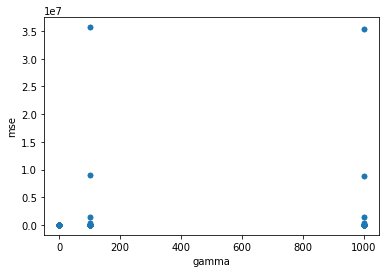

In [111]:
df.plot.scatter(x='gamma',y='mse')

In [112]:
# Row with minimum MSE
df[df.mse == df.mse.min()]

,C,cache_size,coef0,degree,epsilon,gamma,kernel,mae,max_error,max_iter,median_absolute_error,mse,r2,shrinking,tol,verbose
38,50.0,200.0,0.0,3.0,0.3,0.1,rbf,2.840925,33.026689,-1.0,1.869793,18.89747,0.984122,1.0,0.001,0.0


# Set Target to Daily Returns

In [113]:
df = pd.DataFrame()
for m in models:
    model, data, metric = build_forecast_model("ADVANC", historical_data, '2014-01-01', '2016-12-31', custom_svr=m, target_col="DailyReturn")
    # print(m)
    # print(metric)
    # print("="* 20)
    mparams = m.get_params()
    z = {**metric, **mparams}
    df = df.append(z, ignore_index=True)

In [114]:
df

,C,cache_size,coef0,degree,epsilon,gamma,kernel,mae,max_error,max_iter,median_absolute_error,mse,r2,shrinking,tol,verbose
0,0.01,200.0,0.0,3.0,0.1,0.001,rbf,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
1,0.01,200.0,0.0,3.0,0.2,0.001,rbf,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
2,0.01,200.0,0.0,3.0,0.3,0.001,rbf,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
3,0.10,200.0,0.0,3.0,0.1,0.001,rbf,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
4,0.10,200.0,0.0,3.0,0.2,0.001,rbf,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,50.00,200.0,0.0,3.0,0.2,1000.000,sigmoid,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
248,50.00,200.0,0.0,3.0,0.3,1000.000,sigmoid,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
249,100.00,200.0,0.0,3.0,0.1,1000.000,sigmoid,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0
250,100.00,200.0,0.0,3.0,0.2,1000.000,sigmoid,0.011841,0.21473,-1.0,0.007898,0.000433,-0.000389,1.0,0.001,0.0


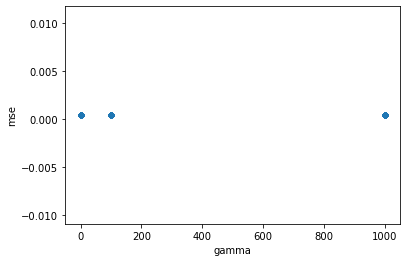

In [115]:
df.plot.scatter(x='gamma',y='mse')

# Test Model

(             High    Low   Open  Close      Volume   Adj Close     SMA  \
 Date                                                                     
 2017-02-16  170.5  168.5  168.5  169.5   7248600.0  148.334946  161.14   
 2017-02-17  174.0  170.5  170.5  171.5  14106500.0  150.085205  161.80   
 2017-02-20  172.5  170.0  172.0  170.0   5758000.0  148.772491  162.44   
 2017-02-21  170.5  168.0  170.0  168.0   6086300.0  147.022232  162.94   
 2017-02-22  169.5  166.5  168.0  169.5   5839200.0  148.334946  163.46   
 ...           ...    ...    ...    ...         ...         ...     ...   
 2018-10-09  197.5  195.0  196.5  195.5   4431700.0  185.471863  199.78   
 2018-10-10  198.5  197.0  197.5  198.5   2315200.0  188.317978  199.78   
 2018-10-11  197.0  194.5  195.0  196.0   7006800.0  185.946243  199.70   
 2018-10-12  197.5  195.5  197.5  196.0   1773600.0  185.946243  199.68   
 2018-10-16  197.5  195.5  196.5  197.5   3298600.0  187.369293  199.62   
 
                    WMA

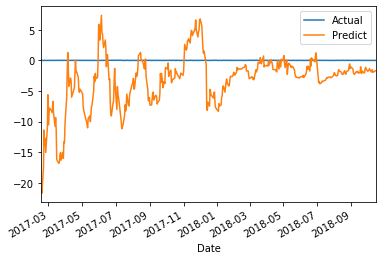

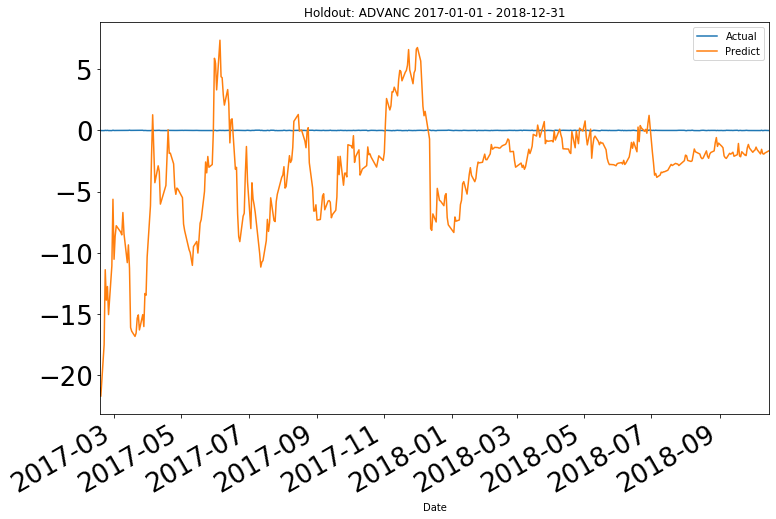

In [154]:
historical_data = {"ADVANC": pd.read_csv("https://raw.githubusercontent.com/chayapan/thesis/master/historical/ADVANC.csv") }

model, data, metric = build_forecast_model("ADVANC", historical_data, '2014-01-01', '2016-12-31', target_col='Return1d')
metric

test_forecast_model_with_holdout_set("ADVANC", model, historical_data, '2017-01-01', '2018-12-31', target_col='Return1d')

In [155]:
df = pd.DataFrame()
for m in models:
    model, data, metric = build_forecast_model("ADVANC", historical_data, '2014-01-01', '2016-12-31', custom_svr=m, target_col='Return1d')
    # print(m)
    # print(metric)
    # print("="* 20)
    mparams = m.get_params()
    z = {**metric, **mparams}
    df = df.append(z, ignore_index=True)

In [156]:
df

,C,cache_size,coef0,degree,epsilon,gamma,kernel,mae,max_error,max_iter,median_absolute_error,mse,r2,shrinking,tol,verbose
0,0.01,200.0,0.0,3.0,0.1,0.001,rbf,0.023519,0.124951,-1.0,0.022209,0.000746,-1.573118,1.0,0.001,0.0
1,0.01,200.0,0.0,3.0,0.2,0.001,rbf,0.064717,0.168293,-1.0,0.065513,0.004475,-14.439882,1.0,0.001,0.0
2,0.01,200.0,0.0,3.0,0.3,0.001,rbf,0.064717,0.168293,-1.0,0.065513,0.004475,-14.439882,1.0,0.001,0.0
3,0.10,200.0,0.0,3.0,0.1,0.001,rbf,0.024443,0.126011,-1.0,0.023607,0.000794,-1.739083,1.0,0.001,0.0
4,0.10,200.0,0.0,3.0,0.2,0.001,rbf,0.064717,0.168293,-1.0,0.065513,0.004475,-14.439882,1.0,0.001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,50.00,200.0,0.0,3.0,0.2,1000.000,linear,0.064717,0.168293,-1.0,0.065513,0.004475,-14.439882,1.0,0.001,0.0
164,50.00,200.0,0.0,3.0,0.3,1000.000,linear,0.064717,0.168293,-1.0,0.065513,0.004475,-14.439882,1.0,0.001,0.0
165,100.00,200.0,0.0,3.0,0.1,1000.000,linear,0.035200,0.145763,-1.0,0.031522,0.001868,-5.445503,1.0,0.001,0.0
166,100.00,200.0,0.0,3.0,0.2,1000.000,linear,0.064717,0.168293,-1.0,0.065513,0.004475,-14.439882,1.0,0.001,0.0


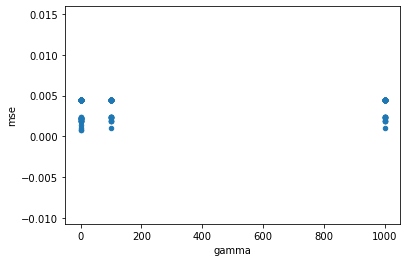

In [158]:
df.plot.scatter(x='gamma',y='mse')

In [157]:
# Row with minimum MSE
df[df.mse == df.mse.min()]

,C,cache_size,coef0,degree,epsilon,gamma,kernel,mae,max_error,max_iter,median_absolute_error,mse,r2,shrinking,tol,verbose
0,0.01,200.0,0.0,3.0,0.1,0.001,rbf,0.023519,0.124951,-1.0,0.022209,0.000746,-1.573118,1.0,0.001,0.0


(             High    Low   Open  Close      Volume   Adj Close     SMA  \
 Date                                                                     
 2017-02-16  170.5  168.5  168.5  169.5   7248600.0  148.334946  161.14   
 2017-02-17  174.0  170.5  170.5  171.5  14106500.0  150.085205  161.80   
 2017-02-20  172.5  170.0  172.0  170.0   5758000.0  148.772491  162.44   
 2017-02-21  170.5  168.0  170.0  168.0   6086300.0  147.022232  162.94   
 2017-02-22  169.5  166.5  168.0  169.5   5839200.0  148.334946  163.46   
 ...           ...    ...    ...    ...         ...         ...     ...   
 2018-10-09  197.5  195.0  196.5  195.5   4431700.0  185.471863  199.78   
 2018-10-10  198.5  197.0  197.5  198.5   2315200.0  188.317978  199.78   
 2018-10-11  197.0  194.5  195.0  196.0   7006800.0  185.946243  199.70   
 2018-10-12  197.5  195.5  197.5  196.0   1773600.0  185.946243  199.68   
 2018-10-16  197.5  195.5  196.5  197.5   3298600.0  187.369293  199.62   
 
                    WMA

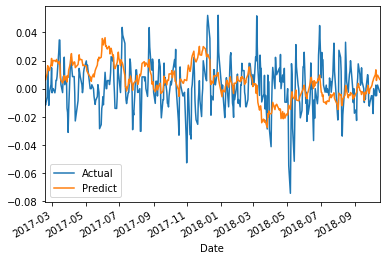

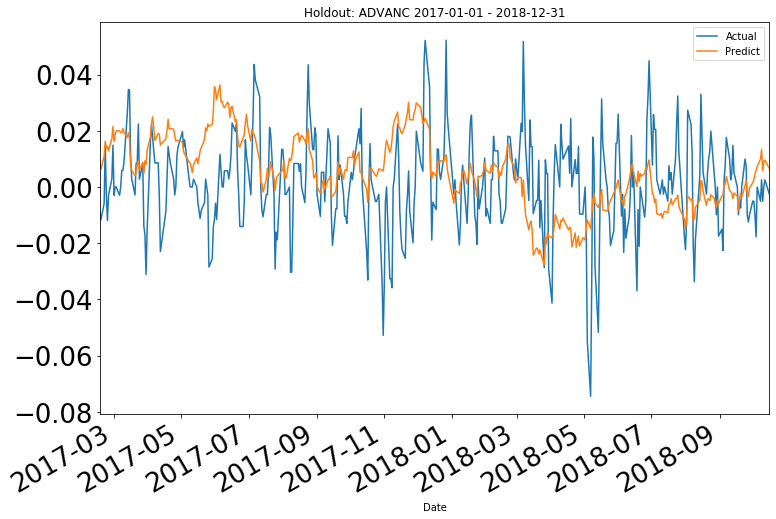

In [169]:
svr = SVR(kernel='linear',gamma=0.001,C=0.01,epsilon=0.1)
model, data, metric = build_forecast_model("ADVANC", historical_data, '2014-01-01', '2016-12-31', custom_svr=svr, target_col='Return3d')
metric

test_forecast_model_with_holdout_set("ADVANC", model, historical_data, '2017-01-01', '2018-12-31', target_col='Return3d')

In [144]:
historical_data["ADVANC"]['Return1d'] = np.log(historical_data["ADVANC"]["Close"].shift(-1)/historical_data["ADVANC"]["Close"])

In [145]:
historical_data["ADVANC"].head()

,Date,High,Low,Open,Close,Volume,Adj Close,Return,DailyReturn,Tomorrow,Return1d
0,2014-01-02,198.5,187.0,198.0,187.0,12694200.0,137.609299,0.047006,0.047006,144.232224,0.047006
1,2014-01-03,196.0,186.5,187.0,196.0,16987100.0,144.232224,0.025190,0.025190,147.911621,0.025190
2,2014-01-06,203.0,191.0,195.0,201.0,10294700.0,147.911621,0.043803,0.043803,154.534515,0.043803
3,2014-01-07,210.0,200.0,205.0,210.0,11479200.0,154.534515,-0.019231,-0.019231,151.591019,-0.019231
4,2014-01-08,210.0,203.0,208.0,206.0,13653100.0,151.591019,-0.014670,-0.014670,149.383392,-0.014670


In [143]:
historical_data["ADVANC"]['Tomorrow'] = historical_data["ADVANC"]["Adj Close"].shift(-1)
historical_data["ADVANC"].head()

,Date,High,Low,Open,Close,Volume,Adj Close,Return,DailyReturn,Tomorrow
0,2014-01-02,198.5,187.0,198.0,187.0,12694200.0,137.609299,0.047006,0.047006,144.232224
1,2014-01-03,196.0,186.5,187.0,196.0,16987100.0,144.232224,0.025190,0.025190,147.911621
2,2014-01-06,203.0,191.0,195.0,201.0,10294700.0,147.911621,0.043803,0.043803,154.534515
3,2014-01-07,210.0,200.0,205.0,210.0,11479200.0,154.534515,-0.019231,-0.019231,151.591019
4,2014-01-08,210.0,203.0,208.0,206.0,13653100.0,151.591019,-0.014670,-0.014670,149.383392
